# Create the features DF
* using by_postal_code dataset

# Import

In [2]:
import pandas as pd
import json
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pickle
import math 
from sklearn.model_selection import train_test_split

from scipy import sparse as sp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [3]:
RANDOM_STATE = 24

In [4]:
res_df = pd.read_pickle ('/home/adam/Steph_C/my_thesis/data/ORI_by_postal_code.pkl').reset_index(drop=True)
venue_df = pd.read_pickle ('../Data/yelp/other_venues.pkl').reset_index(drop=True)
all_df = pd.read_pickle('../Data/yelp/restaurant_only.pkl')

In [6]:
print(res_df.shape , venue_df.shape , all_df.shape)

(250798, 20) (700010, 20) (2112553, 20)


In [7]:
# drop duplicates
df = pd.concat([all_df,venue_df]) # for check in calculation
res_df = res_df.drop_duplicates(subset=['name','postal_code']).reset_index(drop=True)
venue_df = venue_df.drop_duplicates(subset=['name','postal_code']).reset_index(drop=True)
all_df = all_df.drop_duplicates(subset=['name','postal_code']).reset_index(drop=True)

In [11]:
# drop postal_codes not in U.S
drop_postal = [i for i in range(len(all_df)) if not all_df.postal_code[i].isdigit()]
all_df = all_df.drop(drop_postal).reset_index(drop=True)

In [12]:
print(res_df.shape , venue_df.shape , df.shape , all_df.shape)

(1425, 21) (14791, 20) (2812563, 20) (19901, 20)


In [13]:
# create relevance score
cnt = 0
new_df = pd.DataFrame()
for i in Counter(res_df.name):
    tmp = res_df[res_df.name==i].reset_index(drop=True)
    tmp['relevance']=''
    score = 6
    for j in range(len(tmp)):
        tmp['relevance'][j]=score
        score -=1
    new_df = pd.concat([new_df,tmp])

# check the shape
if new_df.shape[0] != res_df.shape[0]:
    print(f'There is a mistake creating the relevance score')
else:
    print(f'Relevance score added')
res_df = new_df

/home/adam/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Relevance score added


In [14]:
# create a overall postal_code features
# postal code and feature dict
postal_code_feature_dict = {}

for postal in Counter(all_df.postal_code):
    
    postal_code_feature_dict[postal]={}
    tmp = df[df.postal_code == postal].reset_index(drop=True)
    tmp_venue = venue_df[venue_df == postal].reset_index(drop=True)
    
    # density 
    postal_code_feature_dict[postal]['density'] = len(Counter(tmp.name))
    
    # neighborhood_entropy
    entropy_sum = 0
    for category in Counter(tmp.categories):
        entropy_sum+=(len(Counter(tmp[tmp.categories==category].name))/len(Counter(tmp.name)))\
        *np.log(len(Counter(tmp[tmp.categories==category].name))/len(Counter(tmp.name)))
    postal_code_feature_dict[postal]['entropy'] = -entropy_sum
    
    # area popularity
    postal_code_feature_dict[postal]['area_pop'] = len(tmp)
    
    # traffic accessibility + complementary
    transportation_cnt = 0
    dep_cnt = 0
    parking_cnt =0
    
    store_cnt = len(Counter(tmp_venue.name))
    
    for i in range(len(tmp_venue)):
        try:
            if 'Public Transportation' in tmp_venue.categories[i]:
                transportation_cnt+=1
            if 'Department Stores' in tmp_venue.categories[i]:
                dep_cnt+=1
            if 'Parking' in tmp_venue.categories[i]:
                parking_cnt+=1
        except:
            pass
    
    postal_code_feature_dict[postal]['accessibility'] = transportation_cnt
    if store_cnt >1:
        postal_code_feature_dict[postal]['complementary'] = (2*(dep_cnt+parking_cnt) )/(store_cnt*(store_cnt-1)) 
    else:
        postal_code_feature_dict[postal]['complementary']=0

In [15]:
len(postal_code_feature_dict)

750

In [16]:
# # # to check the features
# postal_df = pd.DataFrame(postal_code_feature_dict).T.reset_index().rename(columns={'index': 'postal_code'})
# postal_df
# # Counter(postal_df.complementary)

# Train Test Split with Feature Engineering

In [17]:
# POINTWISE
# split train test 
# 拿每一個餐廳一半的分店當作 testing set (雖然大部分只有兩家分店)

cnt = 0
train_df = pd.DataFrame()
test_df = pd.DataFrame()
pos_train_post = Counter()
neg_train_post ={}
for i in Counter(res_df.name):
    
    tmp = res_df[res_df.name==i]
    tmp_train , tmp_test = train_test_split(tmp, test_size=0.33, shuffle= True,random_state=RANDOM_STATE)
    
    postal_df = pd.DataFrame(postal_code_feature_dict).T.reset_index().rename(columns={'index': 'postal_code'})
    postal_df = postal_df.sort_values(['postal_code'],
              ascending = [True]).reset_index(drop=True)
    
    
    # merge with location features
    tmp_train = pd.DataFrame(tmp_train.merge(postal_df, on='postal_code', how='left')).reset_index(drop=True)
    tmp_test = pd.DataFrame(tmp_test.merge(postal_df, on='postal_code', how='left')).reset_index(drop=True)
    pos_train_post += Counter(tmp_train.postal_code)
    ori_train, ori_test = tmp_train.shape , tmp_test.shape
    
    ############################## reconstruct ################################
    postal_codes_list = list(postal_df.postal_code)
    
    
    for j in Counter(tmp_train.postal_code):
        postal_codes_list.remove(j)
    
    for j in Counter(tmp_test.postal_code):
        postal_codes_list.remove(j)
    
    
    ## train 
    tmp_train['competitiveness'] =''
    neg_df = pd.DataFrame()
    
    for j in range(len(tmp_train)):
        
        cnt =0 
        
        # add competitiveness
        place = all_df[all_df.postal_code == tmp_train['postal_code'][j]]
        tmp_train['competitiveness'][j] = -(len(Counter(place[place.categories == tmp_train.categories[j]].name))/len(Counter(place.name)))
    
        ## TO-DO Add reviews 
        
        # add the negative samples
        for k in range(len(postal_df)):
            if cnt<3:
                if postal_df.postal_code[k] in postal_codes_list and\
                abs(int(postal_df.postal_code[k])- int(tmp_train['postal_code'][j])) <= 700:
                    cnt+=1
                    new = pd.DataFrame(tmp_train.iloc[j]).T.reset_index(drop=True)
                    new = new.drop(columns=['density', 'entropy','area_pop', 'accessibility', 'complementary'])
                    new['postal_code'] = postal_df.postal_code[k]
                    postal_codes_list.remove(postal_df.postal_code[k])
                    new = pd.DataFrame(new.merge(postal_df, on='postal_code', how='left'))
                    new['relevance'] = 0
                    # add competitiveness
                    new['competitiveness']=''
                    place = all_df[all_df.postal_code == postal_df.postal_code[k]].reset_index(drop=True)
                    new['competitiveness'] = -(len(Counter(place[place.categories == tmp_train.categories[j]].name))\
                                                  /len(Counter(place.name)))
                    # TO-DO add review 
                    neg_df = pd.concat([neg_df ,new ])
                    
                    ##### create a negative sample dict
                    if postal_df.postal_code[k] in neg_train_post:
                        neg_train_post[postal_df.postal_code[k]] +=1
                    else:
                        neg_train_post[postal_df.postal_code[k]]=1
            else:
                break
    
    tmp_train = pd.concat([tmp_train ,neg_df ])
    
    ## test 
    tmp_test['competitiveness'] =''
    
    neg_df = pd.DataFrame()
    for j in range(len(tmp_test)):
        cnt =0
        
        # add competitiveness
        place = all_df[all_df.postal_code == tmp_test['postal_code'][j]]
        tmp_test['competitiveness'][j] = -(len(Counter(place[place.categories == tmp_test.categories[j]].name))/len(Counter(place.name)))
        
        # TO-DO add review 
        
        # add negative samples
        for k in range(len(postal_df)):
            if cnt<3:
                if postal_df.postal_code[k] in postal_codes_list and\
                abs(int(postal_df.postal_code[k])-int(tmp_test['postal_code'][j])) <= 700:
                    cnt+=1
                    new = pd.DataFrame(tmp_test.iloc[j]).T.reset_index(drop=True)
                    new = new.drop(columns=['density', 'entropy','area_pop', 'accessibility', 'complementary'])
                    new['postal_code'] = postal_df.postal_code[k]
                    postal_codes_list.remove(postal_df.postal_code[k])
                    new = pd.DataFrame(new.merge(postal_df, on='postal_code', how='left'))
                    new['relevance'] = 0
                    # add competitiveness
                    new['competitiveness']=''
                    place = all_df[all_df.postal_code == postal_df.postal_code[k]].reset_index(drop=True)
                    new['competitiveness'] = -(len(Counter(place[place.categories ==tmp_test['categories'][j]].name))/len(Counter(place.name)))
                    
                    # TO-DO add review 
                    
                    neg_df = pd.concat([neg_df ,new ])
            else:
                break
                
    tmp_test = pd.concat([tmp_test ,neg_df ])   
    if int(tmp_train.shape[0]) != int(ori_train[0]*4) or int(tmp_test.shape[0]) != int(ori_test[0]*4):
        print('Original: ' ,ori_train, ori_test )
        print('After : ',tmp_train.shape[0] , tmp_test.shape[0])
        print(f'There is sth wrong !!!!!!!!')
        break
    
    train_df =  pd.concat([train_df ,tmp_train ])
    test_df =  pd.concat([test_df ,tmp_test ])
print(f'Finished constructing....  train : {len(Counter(train_df.name))} test : {len(Counter(test_df.name))}')


/home/adam/.local/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/adam/.local/lib/python3.7/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Finished constructing....  train : 565 test : 565


In [18]:
len(pos_train_post) , len(neg_train_post)

(287, 122)

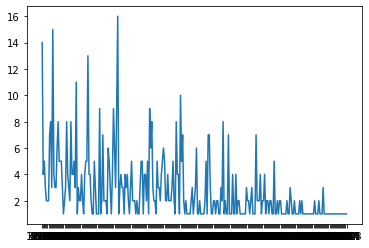

In [21]:
import matplotlib.pyplot as plt
plt.plot(pos_train_post.keys(), pos_train_post.values())

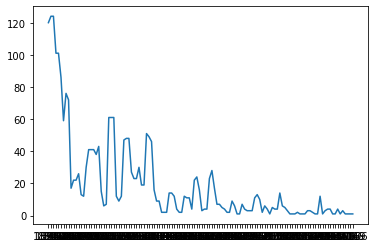

In [22]:
plt.plot(neg_train_post.keys(), neg_train_post.values())

In [58]:
for i in ['density', 'entropy', 'competitiveness','area_pop', 'accessibility','complementary','relevance']:
    train_df[i] = train_df[i].astype('float')
    test_df[i] = test_df[i].astype('float')
train_df.to_pickle('/home/adam/Steph_C/my_thesis/data/Train_by_postoal_code_without_review_pointwise.pkl')
test_df.to_pickle('/home/adam/Steph_C/my_thesis/data/Test_by_postoal_code_without_review_pointwise.pkl')

# Preprocessing 

In [ ]:
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords

In [ ]:
stop_words = stopwords.words('english')

def preprocess(text : str) -> list:
    
    tokens = text.lower().rstrip(' ').rstrip('\n').rstrip('.').split(' ')[:3000]
    
    p = PorterStemmer()
    stemmed_doc =[]
    for token in tokens:
        stemmed_doc.append(p.stem(token))
        
    tokens = [i.split(' ') for i in stemmed_doc]
    
    
    final_tokens =[]


    for l in tokens:
        for word in l:
            word = word.rstrip('.').rstrip('\'').rstrip(',')
            if word not in final_tokens and word not in stop_words and len(word)>0:
                final_tokens.append(word)
    return final_tokens

# Review-based Market Attractiveness Features (MAF)
* Turn every restaurant and city to a doc of reviews
* Use `dict` to store the dic index of restaurant and city
* review - LDA
* location - LDA 

In [ ]:
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import nltk

In [ ]:
# # aspect creation 
# total_df = pd.concat([df,LDA_df] , ignore_index=True)

# docs = []
# index =0 


# # restaurant
# for restaurant in Counter(df.name):
#     if index%10 ==0:
#         print(f'Now {index} Restaurant ... {restaurant}')
#     tmp = df[df.name == restaurant]
#     texts = ''.join(tmp.text.tolist())
#     docs.append(preprocess(texts))
#     indxe +=1

# # city 
# for city_name in Counter(df.city):
#     if index%5 ==0:
#         print(f'Now {index} City ... {city_name}')
#     tmp = total_df[total_df.city == city_name]
#     texts = ''.join(tmp.text.tolist())
#     docs.append(preprocess(texts))
#     index +=1   

# # save pickle
# with open('./data/docs.pkl', 'wb') as f:
#     pickle.dump(docs, f)

In [ ]:
with open('../data/docs.pkl', 'rb') as f:
    docs = pickle.load(f)
    

## LDA

In [ ]:
index = 0
name_city_dict = {}
for restaurant in Counter(df.name):
    name_city_dict[restaurant]=index
    index +=1
    
for city_name in Counter(df.city):
    name_city_dict[city_name]=index
    index +=1   

In [ ]:
### LDA ###
common_dictionary = corpora.Dictionary(docs)
common_corpus = [common_dictionary.doc2bow(text) for text in docs]


# Train the model on the corpus.
lda =  gensim.models.LdaMulticore(corpus = common_corpus, id2word= common_dictionary, num_topics= 10)
lda.show_topics()


In [ ]:
# check the topic coherence
coherence_model_lda = CoherenceModel( model=lda , texts=docs , dictionary=common_dictionary , coherence='c_v' )
conherence_lda = coherence_model_lda.get_coherence()
print(conherence_lda)

In [ ]:
# create restaurant aspects

rest_aspect = {}
loca_aspect = {}

for name in Counter(df.name):
    tmp_arr = np.zeros(10)
    for i in lda[common_corpus[name_city_dict[name]]]:
        tmp_arr[i[0]]=i[1]
    rest_aspect[name]= tmp_arr

for location in Counter(df.city):
    tmp_arr = np.zeros(10)
    for i in lda[common_corpus[name_city_dict[location]]]:
        tmp_arr[i[0]]=i[1]
    loca_aspect[location]= tmp_arr

## Affinity & Complementary

In [ ]:
df = df.reset_index()

In [ ]:
df['affinity']=""
df['complementary']=""

for i in range(len(df)):
    df.affinity[i] = rest_aspect[df.name[i]]*loca_aspect[df.city[i]]
    df.complementary[i] = rest_aspect[df.name[i]]*(1-loca_aspect[df.city[i]]) 

In [ ]:
df.head()

# Review-based Market Competitiveness Feature (MCF)
* review - LDA rank 

# Geographic Features (GeoF)
* Density : the restaurant number in the same postal code
* Neighbourhood Entropy : entropy measure of the frequency of restaurant categories
    * A location with **higher entropy value** is expected to be **more diverse** in terms of restaurant categories,
* Competitiveness : the proportion of nearby restaurants with the same type of restaurant 
* ~~Jensen Quality : Jensen Quality of each venue category as a feature value, rather than simply aggregating Jensen Quality values over all venue categories as a single feature value. ~~
* Area popularity : check in counts in the postal code
* ~~distance from downtown :~~
* Accessibility : transprtation count in the same postal code
* Complementary : Possible dual selection (numbers of parking lot and department stores) / All combination of sets

In [ ]:
res_df.columns

In [ ]:
venue_df.columns

In [ ]:
# create dataset without review
# unhash if neccessary
import math

# calculate the density by Postal code
res_df['density']=""
res_df['entropy']=""
res_df['competitiveness']=""
res_df['area_pop']=""
res_df['accessibility']=""
res_df['complementary']=""

res_cnt = len(Counter(res_df.name))
store_cnt = len(Counter(df.name))

for i in range(len(res_df)):
    
    new_place = new_df[new_df.postal_code == res_df.postal_code[i]]
    place = res_df[res_df.postal_code == res_df.postal_code[i]]
    all_place = df[df.postal_code == res_df.postal_code[i]]
    
    # density 
    res_df.density[i] = len(Counter(place.name))
    
    # entropy
    entropy_sum = 0
    
    for category in Counter(place.categories):
        entropy_sum+=(len(Counter(place[place.categories==category].name))/len(Counter(place.name)))\
        *np.log(len(Counter(place[place.categories==category].name))/len(Counter(place.name)))
    res_df.entropy[i] = -entropy_sum
    
    # Competitiveness
    comp = -(len(Counter(place[place.categories == res_df.categories[i]].name))/len(Counter(place.name)))
    res_df.competitiveness[i]= comp
    
    # Area Popularity
    pop = len(new_place)
    res_df.area_pop[i]= pop
    
    transportation_cnt = 0
    dep_cnt = 0
    parking_cnt =0
    
    for index in range(len(all_place)):
        if 'Public Transportation' in all_place.categories[i]:
            transportation_cnt+=1
        if 'Department Stores' in all_place.categories[i]:
            dep_cnt+=1
        if 'Parking' in all_place.categories[i]:
            parking_cnt+=1
    
    # Accessibility
    res_df.accessibility[i]= transportation_cnt

    # Complementary
    
    res_df.complementary[i] = (2*res_cnt*(dep_cnt+parking_cnt) )/(store_cnt*(store_cnt-1)) 
    
    

res_df.to_pickle("../data/FE_by_postoal_code_without_review.pkl")    
